# <center>CAPM numa abordagem reversa<center>

In [1]:
# Bibliotecas utilizadas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import Bounds
from scipy.optimize import minimize
import yfinance as yf
from numpy.matrixlib.defmatrix import matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
ativos_sa = ['ALPA4.SA', 'ABEV3.SA', 'AMER3.SA', 'ARZZ3.SA', 'AZUL4.SA', 'B3SA3.SA', 'BPAN4.SA', 'BBSE3.SA', 'BRML3.SA',
          'BBDC4.SA', 'BRAP4.SA', 'BBAS3.SA', 'BRKM5.SA', 'BRFS3.SA', 'BPAC11.SA', 'CRFB3.SA', 'CCRO3.SA', 'CMIG4.SA',
          'CIEL3.SA', 'COGN3.SA', 'CPLE6.SA', 'CSAN3.SA', 'CPFE3.SA', 'CVCB3.SA', 'CYRE3.SA', 'DXCO3.SA', 'ECOR3.SA',
          'ELET3.SA', 'ELET6.SA', 'EMBR3.SA', 'ENBR3.SA', 'ENGI11.SA', 'ENEV3.SA', 'EGIE3.SA', 'EQTL3.SA', 'EZTC3.SA',
          'FLRY3.SA', 'GGBR4.SA', 'GOAU4.SA', 'GOLL4.SA', 'NTCO3.SA', 'HYPE3.SA', 'IGTI11.SA', 'IRBR3.SA', 'ITSA4.SA',
          'ITUB4.SA', 'JBSS3.SA', 'KLBN11.SA', 'RENT3.SA', 'LREN3.SA', 'MGLU3.SA', 'MRFG3.SA', 'BEEF3.SA', 'MRVE3.SA',
          'MULT3.SA', 'PCAR3.SA', 'PETR3.SA', 'PETR4.SA', 'PRIO3.SA', 'POSI3.SA', 'QUAL3.SA', 'RADL3.SA', 'RAIL3.SA',
          'SBSP3.SA', 'SANB11.SA', 'SMTO3.SA', 'CSNA3.SA', 'SLCE3.SA', 'SULA11.SA', 'SUZB3.SA', 'TAEE11.SA', 'VIVT3.SA',
          'TIMS3.SA', 'TOTS3.SA', 'UGPA3.SA', 'USIM5.SA', 'VALE3.SA', 'VIIA3.SA', 'WEGE3.SA', 'YDUQ3.SA']
QTD_ASSETS = len(ativos_sa)

In [3]:
data_inicial = '2017-09-29'
data_final = '2022-09-29'

### <center>Valor de Mercado<center>
    
- O peso de cada ativo na composição do portfólio é dado com base no seu valor de mercado.
- É considerada a série histórica de valor de mercado de cada ativo no período definido entre a data inicial e a data final.
- O valor de mercado considerado é a média da série histórica.
- O peso da composição do portfólio é o vetor de valor de mercado normalizado.
- O vetor com os pesos é denominado xm.    

In [4]:
#Valor de mercado dos ativos
df_mktcap = pd.read_excel('Valor_de_mercado.xlsx', sheet_name=['5anos'],index_col = 0)
df_mktcap=df_mktcap['5anos']
df_mktcap.loc[data_inicial:data_final]
mktcap = df_mktcap.loc[data_inicial:data_final].mean()
xm = mktcap/sum(mktcap)
xm_matriz = matrix(xm)

### <center>Ativo livre de risco<center>
    
- A Selic é considerada o ativo livre de risco.
- A série histórica com valores anuais para a Selic é obtida da API do Banco Central.
- É considerada a média da Selic no período compreendido entre a data inicial e a data final e em seguida é realizada a conversão do valor anual para o valor mensal.    

In [5]:
# Obtém informações do ativo livre de risco
def consulta_bc(codigo_bcb):
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df

selic = consulta_bc(432) #puxa base histórica
selic = selic/100
selic = selic.loc[data_inicial:data_final] #utiliza apenas as datas do dataframe
selic.rename({'valor': 'Selic'}, axis=1, inplace=True)

In [6]:
selic.mean().values[0]

0.062022441160372435

In [7]:
MEDIA_SELIC = (1 + selic.mean().values[0])**(1/12)-1
#Pegar a média da selic durante o período estudado. Importante, esta taxa deve estar na mesma unidade dos dados
#se você estiver trabalhando com retornos mensais, então a selic deve ser dada como retorno mensal, ela vem do banco central como
#anual, então tem que fazer a conversão. No material que te passei do curso tem uma função que faz a conversão

In [8]:
RZ = MEDIA_SELIC*np.ones(QTD_ASSETS) #vetor utilizado na função objetivo

In [9]:
MEDIA_SELIC

0.005027181890720822

### <center>Série histórica dos retornos dos ativos<center>

In [56]:
preco_ativos = yf.download(tickers=ativos_sa, start=data_inicial, end=data_final, rounding=True)['Adj Close']
retornos_diarios = preco_ativos.pct_change()
retornos_diarios.columns = retornos_diarios.columns.str.rstrip('.SA') 
retornos_diarios.reset_index(inplace=True)
retornos_diarios=retornos_diarios[1:]

[*********************100%***********************]  80 of 80 completed


In [11]:
ativos = retornos_diarios.columns[1:].tolist()

In [12]:
retornos_mensais = retornos_diarios.set_index('Date').resample('M')[ativos].sum()

In [55]:
import xlsxwriter
writer_portfolio = pd.ExcelWriter('serie_historica_retornos.xlsx', engine='xlsxwriter')
retornos_mensais.to_excel(writer_portfolio, index=True, sheet_name='5 anos')
writer_portfolio.save()

In [13]:
CORR = retornos_mensais.corr() #matriz de correlação dos retornos dos ativos

# <center>Funções Retorno e Risco<center>

In [14]:
def risco_fronteira(desvio):
    return ((np.diag(desvio).dot(CORR)).dot(np.diag(desvio))).dot(xm)

In [15]:
def retorno_fronteira(media_retorno):
    return media_retorno*xm

In [16]:
def risco_proxy_mercado(risco_fronteira):
    return xm.dot(risco_fronteira)

In [17]:
def retorno_proxy_mercado(retorno_fronteira):
    return sum(retorno_fronteira)

# <center>Retorno e Risco - Dados amostrais<center>

In [18]:
M_amostra = retornos_mensais.mean().values
D_amostra = retornos_mensais.std().values

# <center> Fronteira de Pareto -- dados amostrais<center>

In [19]:
risco_fronteira_amostra = risco_fronteira(D_amostra)
risco_fronteira_amostra[:5]

array([0.0035883 , 0.00406712, 0.00577193, 0.00492698, 0.00931673])

In [20]:
retorno_fronteira_amostra = M_amostra*xm
retorno_fronteira_amostra

ABEV3    0.000100
ALPA4    0.000070
AMER3    0.000097
ARZZ3    0.000031
AZUL4    0.000025
           ...   
VALE3    0.002204
VIIA3    0.000011
VIVT3    0.000185
WEGE3    0.000702
YDUQ3    0.000004
Length: 80, dtype: float64

# <center> Proxy da carteira de mercado -- dados amostrais <center>

In [21]:
risco_portfolio_amostra = risco_proxy_mercado(risco_fronteira_amostra)
risco_portfolio_amostra

0.0049879305451686964

In [22]:
retorno_portfolio_amostra = retorno_proxy_mercado(retorno_fronteira_amostra)
retorno_portfolio_amostra

0.017478123215600234

# <center> Retorno e Risco - Dados ajustados <center>

# <center>Solução inicial<center>

In [23]:
retorno_aleatorio = pd.Series(np.random.uniform(M_amostra.min(),M_amostra.max(),QTD_ASSETS))
risco_aleatorio = pd.Series(np.random.uniform(D_amostra.min(),D_amostra.max(),QTD_ASSETS))
X0 = np.array(pd.concat([retorno_aleatorio, risco_aleatorio], axis = 0))

# <center>Parâmetros do problema<center>

In [24]:
#Parâmetros globais
ALPHA = 0.75 #foi fornecido pelos autores
q = 0.001

# <center>Restrições<center>
    

$$\left[\begin{array}{ccccc}
\sigma_1 & 0 & \cdots & 0 & 0 \\ 
0 & \sigma_2 & \cdots & 0 & 0 \\ 
\vdots & \vdots & \ddots & \vdots & \vdots \\ 
0 & 0 & \cdots & \sigma_{n-1} & 0 \\ 
0 & 0 & \cdots & 0 & \sigma_n
\end{array} \right]\times\left[\begin{array}{cccc}
\rho_{1,1} & \rho_{1,2} & \cdots &  \rho_{1,n} \\ 
\rho_{2,1} & \rho_{2,2} & \cdots &  \rho_{2,n} \\ 
\vdots & \vdots & \ddots &  \vdots \\ 
\rho_{n-1,1} & \rho_{n-1,2} & \cdots &  \rho_{n-1,n} \\ 
\rho_{n,1} & \rho_{n,2} & \cdots & \rho_{n,n} \\
\end{array}\right]\times \left[\begin{array}{ccccc}
\sigma_1 & 0 & \cdots & 0 & 0 \\ 
0 & \sigma_2 & \cdots & 0 & 0 \\ 
\vdots & \vdots & \ddots & \vdots & \vdots \\ 
0 & 0 & \cdots & \sigma_{n-1} & 0 \\ 
0 & 0 & \cdots & 0 & \sigma_n
\end{array} \right]\times\left[\begin{array}{c}
x_{m_1} \\ 
x_{m_2} \\ 
\vdots \\ 
x_{m_(n-1)} \\ 
x_{m_n}
\end{array} \right]=q\left[\begin{array}{c}
\mu_1-rz \\ 
\mu_2-rz \\ 
\vdots \\ 
\mu_{n-1}-rz \\ 
\mu_n-rz
\end{array} \right]$$



In [25]:
def constraint_eq(x):
    desvio = x[QTD_ASSETS:]
    media = x[:QTD_ASSETS]
    return (((np.diag(desvio)).dot(CORR)).dot(np.diag(desvio))).dot(xm)-q*(media-RZ)

# <center>Variável x:<center>
<center>- x[:QTD_ASSETS] $\rightarrow$ média<center>
<center>- x[QTD_ASSETS:] $\rightarrow$ desvio<center>

In [26]:
#Definição dos limites inferiores e superiores das variáveis
limites_inferiores = np.append(0*np.ones(QTD_ASSETS),D_amostra.min()*np.ones(QTD_ASSETS))
limites_superiores = np.append(M_amostra.max()*np.ones(QTD_ASSETS),D_amostra.max()*np.ones(QTD_ASSETS))
bnds = Bounds(limites_inferiores, limites_superiores)

### <center>Função objetivo<center>
    
$$D((\mu,\sigma),(\mu^{amostra},\sigma^{amostra}))=\sqrt{\alpha\frac{1}{n}\displaystyle\sum_{i=1}^n\left(\dfrac{\mu_i-\mu_i^{amostra}}{\sigma_i^{amostra}}\right)^2+(1-\alpha)\frac{1}{n}\displaystyle\sum_{i=1}^n\left(\dfrac{\sigma_i-\sigma_i^{amostra}}{\sigma_i^{amostra}}\right)^2}$$    

In [27]:
def objective(x):
    parcela_retorno = sum(((x[:QTD_ASSETS]-M_amostra)/D_amostra)**2)
    parcela_risco = sum(((x[QTD_ASSETS:]-D_amostra)/D_amostra)**2)
    soma = ALPHA*(1/QTD_ASSETS)*parcela_retorno+(1-ALPHA)*(1/QTD_ASSETS)*parcela_risco
    return np.sqrt(soma)

### <center>Algoritmo de otimização<center>

In [28]:
#Aqui você está minizando a função objetivo dada no artigo e definida pela função objective obecendo às restrições dadas no artigo
#e definidas na função constraint_eq, note que aqui só estamos trabalhando com restrições de desigualdade
#Você está utilizando o método de otimização SLSQP. A forma como está definida é a maneira mais simples de resolver este problema
solution = minimize(objective,X0,method='SLSQP', bounds=bnds,constraints={'type': 'eq', 'fun': constraint_eq},options={'ftol': 1e-15, 'disp': True})

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 0.49802528295362547
            Iterations: 27
            Function evaluations: 3838
            Gradient evaluations: 23


In [29]:
MediaOtima = solution.x[:QTD_ASSETS]
MediaOtima[:5]

array([0.00000000e+00, 5.67875703e-11, 1.11298367e-10, 0.00000000e+00,
       0.00000000e+00])

In [30]:
DesvioOtimo = solution.x[QTD_ASSETS:]
DesvioOtimo[:5]

array([0.09401325, 0.19712567, 0.04497376, 0.14372224, 0.21224715])

### <center>Fronteira de Pareto - dados ajustados<center>

In [31]:
retorno_fronteira_ajustado = retorno_fronteira(MediaOtima)
retorno_fronteira_ajustado[:5]

ABEV3    0.000000e+00
ALPA4    2.199080e-13
AMER3    7.873143e-13
ARZZ3    0.000000e+00
AZUL4    0.000000e+00
dtype: float64

In [32]:
risco_fronteira_ajustado = risco_fronteira(DesvioOtimo)
risco_fronteira_ajustado[:5]

array([0.00496596, 0.00776326, 0.0018302 , 0.00787941, 0.01271499])

### <center>Proxy da carteira de mercado - dados ajustados<center>

In [33]:
risco_portfolio_ajustado = risco_proxy_mercado(risco_fronteira_ajustado)
risco_portfolio_ajustado

0.006874419232368998

In [34]:
retorno_portfolio_ajustado = retorno_proxy_mercado(retorno_fronteira_ajustado)
retorno_portfolio_ajustado

0.0005997689283076957

# <center>Gráfico Fronteira de Pareto<center>

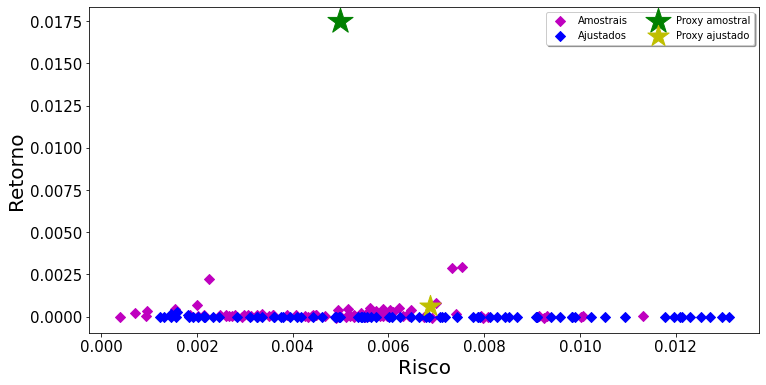

In [35]:
from numpy.core import multiarray
gráfico = plt.figure(figsize = (12,6))
plt.scatter(risco_fronteira_amostra,retorno_fronteira_amostra,marker='D',s=50,c="m",label='Amostrais')
plt.scatter(risco_fronteira_ajustado,retorno_fronteira_ajustado,marker='D',s=50,c="b",label='Ajustados')
plt.scatter(risco_portfolio_amostra,retorno_portfolio_amostra,marker='*',s=700,c="g",label='Proxy amostral')
plt.scatter(risco_portfolio_ajustado,retorno_portfolio_ajustado,marker='*',s=500,c="y",label='Proxy ajustado')
plt.xlabel('Risco', fontsize=20)
plt.ylabel('Retorno', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
legend = plt.legend(loc='upper right', shadow=True, fontsize=10, ncol = 2)
#plt.axis([0.00005, 0.00033, 0.0024, 0.0065]) # [xmin, xmax, ymin, ymax]
plt.show()

# <center>Cálculo do Beta<center>

In [36]:
def calcula_beta(desvio):
    beta = np.zeros(QTD_ASSETS)
    denominador = (xm.dot((np.diag(desvio).dot(CORR)).dot(np.diag(desvio)))).dot(xm)
    for ativo in range(QTD_ASSETS):
        numerador = sum([xm.values[pos]*desvio[ativo]*desvio[pos]*CORR.iloc[ativo,pos] for pos in range(QTD_ASSETS)])
        beta[ativo] = numerador/denominador
    return beta    

beta_amostral = calcula_beta(D_amostra)
beta_ajustado = calcula_beta(DesvioOtimo)

# <center>Teste de Normalidade<center>

In [37]:
from scipy.stats import normaltest
import seaborn as sns
from scipy import stats

In [38]:
# Teste 1
ALPHA = 0.05
def calcula_shapiro(vetor):
    sns.distplot(a=vetor, hist=True)
    p_shapiro = stats.shapiro(vetor).pvalue

    #Hipotese nula: Os dados seguem distribuição normal
    #Hipotese alternativa: Os dados não seguem distribuição normal

    if p_shapiro < ALPHA:
        print(f'p-valor:{round(p_shapiro,2)} - A Hipótese Nula pode ser rejeitada - os dados não são normais')
    else:
        print(f'p-valor:{round(p_shapiro,2)} -A hipótese nula não pode ser rejeitada - não é possível afirmar que os dados não são normais')
    return     

## <center>Testando normalidade do Beta Amostral<center>

p-valor:0.33 -A hipótese nula não pode ser rejeitada - não é possível afirmar que os dados não são normais


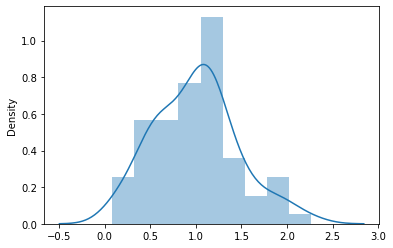

In [39]:
calcula_shapiro(beta_amostral)

## <center>Testando normalidade do Beta Ajustado<center>

p-valor:0.01 - A Hipótese Nula pode ser rejeitada - os dados não são normais


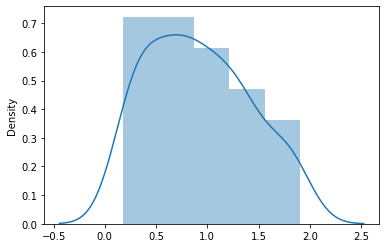

In [40]:
calcula_shapiro(beta_ajustado)

## <center>Testando normalidade - Risco fronteira ajustado<center>

p-valor:0.01 - A Hipótese Nula pode ser rejeitada - os dados não são normais


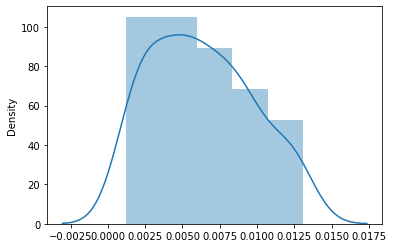

In [41]:
calcula_shapiro(risco_fronteira_ajustado)

## <center>Testando normalidade - Risco fronteira amostral<center>

p-valor:0.33 -A hipótese nula não pode ser rejeitada - não é possível afirmar que os dados não são normais


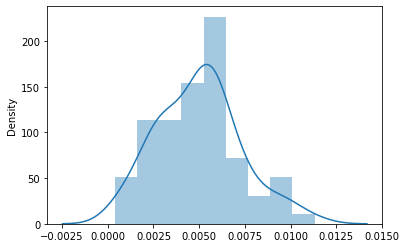

In [42]:
calcula_shapiro(risco_fronteira_amostra)

## <center>Testando normalidade - Retorno fronteira amostral<center>

p-valor:0.0 - A Hipótese Nula pode ser rejeitada - os dados não são normais


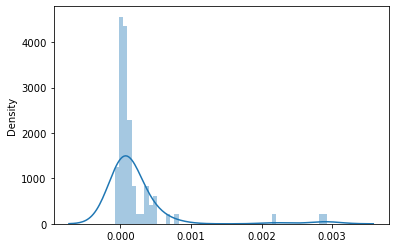

In [43]:
calcula_shapiro(retorno_fronteira_amostra)

## <center>Testando normalidade - Retorno fronteira ajustado<center>

p-valor:0.0 - A Hipótese Nula pode ser rejeitada - os dados não são normais


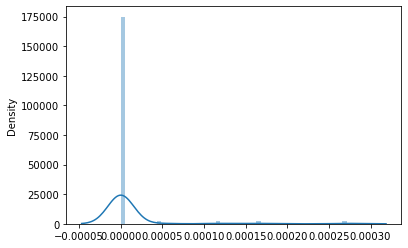

In [44]:
calcula_shapiro(retorno_fronteira_ajustado)

# <center>Testes de comparação<center>

Os testes wilcoxon e mannwhitneyu são utilizados quando os dados não são normais

In [45]:
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

In [46]:
def calcula_wilcoxon(vetor1,vetor2):
    res_retorno = wilcoxon(vetor1,vetor2)
    p_wilcoxon = res_retorno.pvalue
    if p_wilcoxon < ALPHA:
        print(f'p-valor:{round(p_wilcoxon,2)} - A Hipótese Nula pode ser rejeitada - os dados não são iguais')
    else:
        print(f'p-valor:{round(p_wilcoxon,2)} -A hipótese nula não pode ser rejeitada - não é possível afirmar que os dados não são iguais')
    return     

In [47]:
def calcula_mannwhitneyu(vetor1,vetor2):
    res_retorno = mannwhitneyu(vetor1,vetor2)
    p_mannwhitneyu = res_retorno.pvalue
    if p_mannwhitneyu < ALPHA:
        print(f'p-valor:{round(p_mannwhitneyu,2)} - A Hipótese Nula pode ser rejeitada - os dados não são iguais')
    else:
        print(f'p-valor:{round(p_mannwhitneyu,2)} -A hipótese nula não pode ser rejeitada - não é possível afirmar que os dados não são iguais')
    return     

## <center>Teste comparação - Retorno<center>

In [48]:
calcula_wilcoxon(retorno_fronteira_amostra,retorno_fronteira_ajustado)

p-valor:0.0 - A Hipótese Nula pode ser rejeitada - os dados não são iguais


In [49]:
calcula_mannwhitneyu(retorno_fronteira_amostra,retorno_fronteira_ajustado)

p-valor:0.0 - A Hipótese Nula pode ser rejeitada - os dados não são iguais


# <center>Teste comparação - Risco<center>

In [50]:
calcula_wilcoxon(risco_fronteira_amostra,risco_fronteira_ajustado)

p-valor:0.0 - A Hipótese Nula pode ser rejeitada - os dados não são iguais


In [51]:
calcula_mannwhitneyu(risco_fronteira_amostra,risco_fronteira_ajustado)

p-valor:0.01 - A Hipótese Nula pode ser rejeitada - os dados não são iguais


# <center>Teste comparação - Betas<center>

In [52]:
calcula_wilcoxon(beta_amostral,beta_ajustado)

p-valor:0.47 -A hipótese nula não pode ser rejeitada - não é possível afirmar que os dados não são iguais


In [53]:
calcula_mannwhitneyu(beta_amostral,beta_ajustado)

p-valor:0.13 -A hipótese nula não pode ser rejeitada - não é possível afirmar que os dados não são iguais
